In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from torchvision.datasets import ImageFolder
import torchvision.transforms.v2 as F
from torch.utils.data import DataLoader

from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

from models import SimpleModel

import pandas as pd
import matplotlib.pyplot as plt

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"

os.environ["CUDA_VISIBLE_DEVICES"]="1"

os.environ['JOBLIB_TEMP_FOLDER'] = '/home/msiau/workspace/jventosa/PostTFG/Master/project-1/Week2/joblib'

In [9]:
transform = F.Compose([
    F.ToImage(),
    F.ToDtype(torch.float32, scale=True),
    F.Resize((224,224)),
])

train_data = ImageFolder(
    "../places_reduced/train",
    transform=transform
)

test_data = ImageFolder(
    "../places_reduced/val",
    transform=transform
)

train_loader = DataLoader(train_data, batch_size=128, shuffle=False)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [10]:
C, H, W = train_data[0][0].shape

model = SimpleModel(
    input_d=C*H*W,
    hidden_d=300,
    hidden_layers_n=2,
    output_d=11
)

model.load_state_dict(torch.load("trained_mlp.pth", map_location=device))
model.to(device)
model.eval()


/tmp/ipykernel_200149/3065083344.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("trained_mlp.pth", map_location=device))


SimpleModel(
  (activation): ReLU()
  (layers): ModuleList(
    (0): Linear(in_features=150528, out_features=300, bias=True)
    (1-2): 2 x Linear(in_features=300, out_features=300, bias=True)
    (3): Linear(in_features=300, out_features=11, bias=True)
  )
)

In [11]:
def evaluate_end2end(model, loader):
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            out = model(imgs)
            pred = out.argmax(dim=1)
            correct += (pred == labels).sum().item()
            total += labels.size(0)
    return correct / total

end2end_acc = evaluate_end2end(model, test_loader)
print(f"End-to-end MLP accuracy: {end2end_acc:.4f}")


End-to-end MLP accuracy: 0.2609


In [12]:
def extract_features(model, loader, layer_id):
    feats, labels = [], []

    with torch.no_grad():
        for imgs, lbls in loader:
            imgs = imgs.to(device)
            f = model.recover_layer(imgs, layer_id)
            feats.append(f.cpu().numpy())
            labels.append(lbls.numpy())

    return np.vstack(feats), np.hstack(labels)


In [13]:
results_task4 = {}

for layer_id in [0, 1, 2]:
    X_train, y_train = extract_features(model, train_loader, layer_id)
    X_test, y_test   = extract_features(model, test_loader, layer_id)

    svm = LinearSVC(C=1.0)
    svm.fit(X_train, y_train)

    y_pred = svm.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    results_task4[layer_id] = acc
    print(f"SVM accuracy using layer {layer_id}: {acc:.4f}")


/home/msiau/workspace/jventosa/miniconda3/envs/C3_Team1/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/msiau/workspace/jventosa/miniconda3/envs/C3_Team1/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


SVM accuracy using layer 0: 0.2000


/home/msiau/workspace/jventosa/miniconda3/envs/C3_Team1/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/msiau/workspace/jventosa/miniconda3/envs/C3_Team1/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


SVM accuracy using layer 1: 0.1968


/home/msiau/workspace/jventosa/miniconda3/envs/C3_Team1/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


SVM accuracy using layer 2: 0.2527


/home/msiau/workspace/jventosa/miniconda3/envs/C3_Team1/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [14]:
task4_df = pd.DataFrame({
    "Method": ["End-to-end MLP"] + [f"SVM layer {l}" for l in results_task4.keys()],
    "Accuracy": [end2end_acc] + list(results_task4.values())
})

task4_df


,Method,Accuracy
0,End-to-end MLP,0.260909
1,SVM layer 0,0.200000
2,SVM layer 1,0.196818
3,SVM layer 2,0.252727


In [15]:
print("Task 4 — Single feature descriptor comparison\n")
print(f"End-to-end MLP accuracy: {end2end_acc:.4f}\n")

for layer_id, acc in results_task4.items():
    print(f"SVM on layer {layer_id}: {acc:.4f}")

Task 4 — Single feature descriptor comparison

End-to-end MLP accuracy: 0.2609

SVM on layer 0: 0.2000
SVM on layer 1: 0.1968
SVM on layer 2: 0.2527


In [16]:
def extract_patches(image, patch_size=64, stride=64):
    C, H, W = image.shape
    patches = []
    for y in range(0, H - patch_size + 1, stride):
        for x in range(0, W - patch_size + 1, stride):
            patches.append(image[:, y:y+patch_size, x:x+patch_size])
    return patches

In [17]:
def predict_patch_end2end(model, image):
    patches = extract_patches(image)
    probs = []

    with torch.no_grad():
        for p in patches:
            p = F.Resize((224,224))(p)
            p = p.unsqueeze(0).to(device)
            out = model(p)
            probs.append(torch.softmax(out, dim=1))

    return torch.stack(probs).mean(dim=0)

In [18]:
correct = 0
for img, label in test_data:
    pred = predict_patch_end2end(model, img)
    if pred.argmax().item() == label:
        correct += 1

patch_end2end_acc = correct / len(test_data)
print(f"Patch-based end-to-end accuracy: {patch_end2end_acc:.4f}")

Patch-based end-to-end accuracy: 0.2082


In [19]:
def extract_dense_descriptors(model, dataset, layer_id):
    feats, labels = [], []

    with torch.no_grad():
        for img, label in dataset:
            patches = extract_patches(img)
            img_feats = []

            for p in patches:
                p = F.Resize((224,224))(p)
                p = p.unsqueeze(0).to(device)
                f = model.recover_layer(p, layer_id)
                img_feats.append(f.squeeze(0).cpu().numpy())

            feats.append(np.vstack(img_feats))
            labels.append(label)

    return feats, np.array(labels)


In [20]:
from sklearn.cluster import MiniBatchKMeans

layer_id = 1
K = 256

train_feats, train_labels = extract_dense_descriptors(model, train_data, layer_id)
test_feats, test_labels   = extract_dense_descriptors(model, test_data, layer_id)

kmeans = MiniBatchKMeans(n_clusters=K, batch_size=2048)
kmeans.fit(np.vstack(train_feats))

/home/msiau/workspace/jventosa/miniconda3/envs/C3_Team1/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


MiniBatchKMeans(batch_size=2048, n_clusters=256)

In [21]:
def bow_histogram(desc, kmeans):
    words = kmeans.predict(desc)
    hist, _ = np.histogram(words, bins=np.arange(K+1))
    hist = hist / (hist.sum() + 1e-6)
    return hist

X_train = np.array([bow_histogram(f, kmeans) for f in train_feats])
X_test  = np.array([bow_histogram(f, kmeans) for f in test_feats])

svm = LinearSVC()
svm.fit(X_train, train_labels)

y_pred = svm.predict(X_test)
bow_acc = accuracy_score(test_labels, y_pred)

print(f"BoW + SVM accuracy: {bow_acc:.4f}")


/home/msiau/workspace/jventosa/miniconda3/envs/C3_Team1/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


BoW + SVM accuracy: 0.2577


In [22]:

# COMPARISON TABLE

task5_df = pd.DataFrame({
    "Method": [
        "End-to-end (full image)",
        "Patch-based end-to-end",
        "BoW + SVM"
    ],
    "Accuracy": [
        end2end_acc,
        patch_end2end_acc,
        bow_acc
    ]
})

task5_df


,Method,Accuracy
0,End-to-end (full image),0.260909
1,Patch-based end-to-end,0.208182
2,BoW + SVM,0.257727


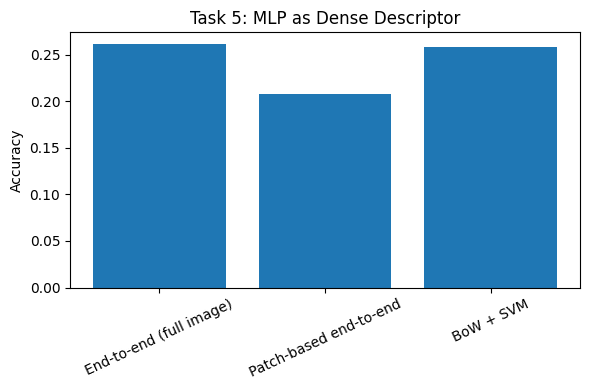

In [23]:
plt.figure(figsize=(6,4))
plt.bar(task5_df["Method"], task5_df["Accuracy"])
plt.ylabel("Accuracy")
plt.title("Task 5: MLP as Dense Descriptor")
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()


In [24]:
print("\nFINAL COMPARISON\n")

print(f"End-to-end MLP:            {end2end_acc:.4f}")
print(f"Patch-based end-to-end:    {patch_end2end_acc:.4f}")

for layer_id, acc in results_task4.items():
    print(f"SVM (layer {layer_id}):         {acc:.4f}")

print(f"BoW + SVM (layer {layer_id}):   {bow_acc:.4f}")



FINAL COMPARISON

End-to-end MLP:            0.2609
Patch-based end-to-end:    0.2082
SVM (layer 0):         0.2000
SVM (layer 1):         0.1968
SVM (layer 2):         0.2527
BoW + SVM (layer 2):   0.2577


In [25]:
# FINAL 
final_df = pd.DataFrame({
    "Method": [
        "End-to-end MLP",
        "Patch-based end-to-end",
        "Best SVM layer",
        "BoW + SVM"
    ],
    "Accuracy": [
        end2end_acc,
        patch_end2end_acc,
        max(results_task4.values()),
        bow_acc
    ]
})

final_df


,Method,Accuracy
0,End-to-end MLP,0.260909
1,Patch-based end-to-end,0.208182
2,Best SVM layer,0.252727
3,BoW + SVM,0.257727


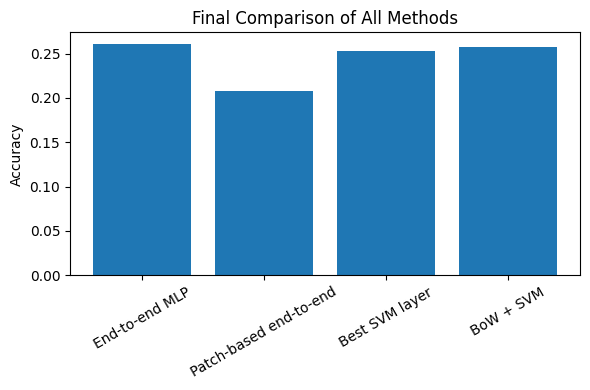

In [26]:
plt.figure(figsize=(6,4))
plt.bar(final_df["Method"], final_df["Accuracy"])
plt.ylabel("Accuracy")
plt.title("Final Comparison of All Methods")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()
